In [1]:
import logic.pulsed.pulse_objects as po
from logic.pulsed.sampling_functions import SamplingFunctions as SF
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
pjl = pulsedjupyterlogic_AWG #Make sure the Logic is started in the Qudi manager!!!!
import pickle
import datetime
from logic import gwyfile as gwy
import numpy as np

###### Measurement parameters

In [2]:
#measurement parameters
pi_pulse = 93e-9

#Driving information for the first LO (SMBV)
target_freq_0 = 4.6641e9 #initial resonance frequency
LO_freq_0 = target_freq_0 + 100e6
power_0 = 0

#Driving information for the second LO (SGS)
target_freq_1 = 3e9
LO_freq_1 = target_freq_1 + 100e6
power_1 = -100#-20.7

#Information for running tracking mode
tracking_repetitions = 1
delta_freq = 5e6
# slope = 1.73e-9
slope = afm_scanner_logic._podmr.vis_slope

max_sweeps_tracking =150e3 #Number of sweeps for tracking pulsed measurements
max_sweeps_T2 =400e3 #Number of sweeps for T2 related pulsed measurements

#Information for running the fast Hahn Echo measurement
tau_ref = pi_pulse + 1e-9
tau_max = 0.8e-6

#Scan area
scan_start_x=9.6e-6
scan_stop_x=11.6e-6
scan_step_x=100

scan_start_y=9.9e-6 
scan_stop_y=11.9e-6
scan_step_y=100

retract = True

#additional information for save tag
tip_name = 'A-P08-05'
sample = 'NbSe2_S4_rot'
temperature = '2.0K'
b_field = '70mT_OOP_sFC'
contact = 'IC'
extra = 'Set_C'

afm_scanner_logic.jupyter_meas_stop = False
afm_scanner_logic.jupyter_meas_pause = False

###### Helper functions

In [3]:
def prepare_AWG_sequence_mode(pi_pulse, init_res_freq, power, delta_freq, tau_ref, tau_max):
    
    ensemble_list = []
    tau_arr_list = []
    alternating_list = []
    freq_sweep_list = []
    
    pjl.initialize_ensemble(pi_pulse=pi_pulse, LO_freq_0=init_res_freq + 100e6, target_freq_0=init_res_freq, power_0=power, printing = False, upload = False, set_up_measurement = False)
    AWG_ensemble_list, PS_seq_name, tau_arr, alternating, freq_sweep = pjl.Tracking(init_res_freq, delta_freq)
    ensemble_list.append(AWG_ensemble_list[0])
    tau_arr_list.append(tau_arr)
    alternating_list.append(alternating)
    freq_sweep_list.append(freq_sweep)

    AWG_ensemble_list, PS_seq_name, tau_arr, alternating, freq_sweep =pjl.Hecho_alt_phased(tau_ref, tau_ref, 1, name = 'hecho-alt-phased-juptr-ref')
    ensemble_list.append(AWG_ensemble_list[0])
    tau_arr_list.append(tau_arr)
    alternating_list.append(alternating)
    freq_sweep_list.append(freq_sweep)
    
    AWG_ensemble_list, PS_seq_name, tau_arr, alternating, freq_sweep =pjl.Hecho_alt_phased(tau_max, tau_max, 1, name = 'hecho-alt-phased-juptr-sig')
    ensemble_list.append(AWG_ensemble_list[0])
    tau_arr_list.append(tau_arr)
    alternating_list.append(alternating)
    freq_sweep_list.append(freq_sweep)
    
    explicit_steps_list = []
    for idx, name in enumerate(ensemble_list):
        explicit_steps_list.append({"step_index" : idx,
                    "step_segment" : name,
                    "step_loops" : 1,
                    "next_step_index" : idx,
                    "step_end_cond" : 'always'
                    })
    
    sequence_step_list = explicit_steps_list
    pjl.AWG_MW_reset()
    pjl.AWG.load_ready_sequence_mode(sequence_step_list)

    return ensemble_list, tau_arr_list, alternating_list, freq_sweep_list, sequence_step_list

def run_measurement(idx, AWG_ensemble_name, tau_arr, alternating, freq_sweep, res_freq, power, max_sweeps, change_freq = True):
    
    tau_num = len(tau_arr) * 2 if alternating else len(tau_arr)
    pjl.pulsed_master_AWG.set_fast_counter_settings(record_length=pjl.read_out_time, number_of_gates=tau_num)
    pjl.pulsed_master_AWG.set_measurement_settings(invoke_settings=False, 
                                controlled_variable=tau_arr,
                                number_of_lasers=tau_num, 
                                laser_ignore_list=[], 
                                alternating=alternating, 
                                units=('Hz' if freq_sweep else 's', 'arb. u.'))
    pjl.pulsed_master_AWG.pulsedmeasurementlogic().alternative_data_type = 'None'
    pjl.AWG.instance.set_sequence_start_step(idx)
        
    if change_freq:
        pjl.pulsed_master_AWG.set_ext_microwave_settings(use_ext_microwave=True, 
                                                frequency=res_freq + 100e6,
                                                power=power)
    
    pulsedmeasurementlogic_AWG._PulsedMeasurementLogic__elapsed_sweeps = 0
    pjl.start_measurement(measurement_type=AWG_ensemble_name, tip_name=tip_name, sample=sample, 
                          temperature=temperature, b_field=b_field, contact=contact, extra=extra, printing = False)

    while True:
        if pulsedmasterlogic_AWG.elapsed_sweeps>max_sweeps:
            pulsedmeasurementlogic_AWG.stop_pulsed_measurement()
            result = afm_scanner_logic.analyse_pulsed_meas(pulsedmasterlogic_AWG.analysis_settings, pulsedmeasurementlogic_AWG.laser_data, alternating)
            if alternating:
                return pulsedmeasurementlogic_AWG.signal_data[1], pulsedmeasurementlogic_AWG.signal_data[2], pulsedmeasurementlogic_AWG.signal_data[1] - pulsedmeasurementlogic_AWG.signal_data[2], np.mean(result[0][2])/result[0][3]
            else:
                return pulsedmeasurementlogic_AWG.signal_data[1], np.mean(result[2])/result[3]
        else:
            time.sleep(0.001)

def tracking_analysis(pulsed_ret0, slope2_podmr, prev):
    visibility = (pulsed_ret0[1] - pulsed_ret0[0])/(pulsed_ret0[1] + pulsed_ret0[0])
    new_res_freq =  prev - visibility/slope2_podmr

    return new_res_freq, visibility

def goto(x_pos, y_pos):
    while True:
        if spm._dev.base.getParameter(spm._dev.base.getConst('ID_SCAN_STATUS'), 0)==2:
            time.sleep(0.001)
        else:
            break
    afm_scanner_logic.set_afm_pos({'x':x_pos, 'y':y_pos})
    time.sleep(0.001)
    while True:
        if spm._dev.base.getParameter(spm._dev.base.getConst('ID_SCAN_STATUS'), 0)==2:
            time.sleep(0.001)
        else:
            break

def get_topo(reps=5):
    topo = 0
    for i in range(reps):
        topo =+ spm.get_sample_pos()['Z']
        time.sleep(0.005)
    return spm.get_sample_scan_range()['Z'] - topo/reps

def measurement_loop(scan_start_x, scan_stop_x, scan_step_x, scan_start_y, scan_stop_y, scan_step_y, power, pi_pulse, init_res_freq, delta_freq, slope, tracking_repetitions, max_sweeps_tracking, max_sweeps_T2, tau_max, tau_ref, path):
    afm_scanner_logic.jupyter_meas_stop = False
    afm_scanner_logic.jupyter_meas_pause = False
    
    scan_array_x = np.linspace(scan_start_x, scan_stop_x, scan_step_x)
    scan_array_y = np.linspace(scan_start_y, scan_stop_y, scan_step_y)
    
    topography = np.zeros((scan_step_y,scan_step_x))
    counts = np.zeros((scan_step_y,scan_step_x))
    res_freq = np.zeros((scan_step_y,scan_step_x))
    T2_ref = np.ones((scan_step_y,scan_step_x))
    T2_ref_raw = np.zeros((scan_step_y,scan_step_x))
    T2_ref_raw_alt = np.zeros((scan_step_y,scan_step_x))
    T2_sig = np.zeros((scan_step_y,scan_step_x))
    T2_sig_raw = np.zeros((scan_step_y,scan_step_x))
    T2_sig_raw_alt = np.zeros((scan_step_y,scan_step_x))

    spm.set_sample_scanner_speed(500)
    
    #Deactivate the printing of information into the manager log as this is time intensive
    awg_spectrum.print_log_info = False
    sequencegeneratorlogic_AWG.print_log_info = False
    sequencegeneratorlogic.print_log_info = False
    
    afm_scanner_logic._pulsed_master_AWG.pulsedmeasurementlogic().alternative_data_type = 'None'
    
    #Create needed sequences for the pulsestremaer and the AWG
    ensemble_list, tau_arr_list, alternating_list, freq_sweep_list, sequence_step_list = prepare_AWG_sequence_mode(pi_pulse, init_res_freq, power, delta_freq, tau_ref, tau_max)
    
    start_time = datetime.datetime.now()
    
    meas_dict = {}

    meas_dict = {'params': {'Parameters for': 'Resonance tracking and fast Hahn Echo scan'}}
    meas_dict['params']['axis name for coord0'] = 'X'
    meas_dict['params']['axis name for coord1'] = 'Y'
    meas_dict['params']['coord0_start (m)'] = scan_start_x
    meas_dict['params']['coord0_stop (m)'] = scan_stop_x
    meas_dict['params']['coord0_num (#)'] = scan_step_x
    meas_dict['params']['coord1_start (m)'] = scan_start_y
    meas_dict['params']['coord1_stop (m)'] = scan_stop_y
    meas_dict['params']['coord1_num (#)'] = scan_step_y

    meas_dict['params']['MW power (dBm)'] = power_0
    meas_dict['params']['Pi pulse Duration (s)'] = pi_pulse
    meas_dict['params']['Initial resonance frequency (Hz)'] = init_res_freq
    meas_dict['params']['Delta_0 (Hz)'] = delta_freq
    meas_dict['params']['Slope (a.u.)'] = slope
    meas_dict['params']['Tracking repetitions (#)'] = tracking_repetitions
    meas_dict['params']['Hahn Echo waiting time (s)'] = tau_max
    meas_dict['params']['Measurement runs tracking (#)'] = max_sweeps_tracking
    meas_dict['params']['Measurement runs T2 (#)'] = max_sweeps_T2

    meas_dict['params']['Measurement start'] = start_time.isoformat('_','seconds')
    meas_dict['params']['Measurement stop'] = datetime.datetime.now().isoformat('_','seconds')

    meas_dict.update({'topo': {'data': topography}})
    meas_dict['topo']['coord0_arr'] = scan_array_x
    meas_dict['topo']['coord1_arr'] = scan_array_y
    meas_dict['topo']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    meas_dict['topo']['xy_units'] = 'm'
    meas_dict['topo']['si_units'] = 'm'
    meas_dict['topo']['nice_name'] = 'Topography'

    meas_dict.update({'counts': {'data': counts}})
    meas_dict['counts']['coord0_arr'] = scan_array_x
    meas_dict['counts']['coord1_arr'] = scan_array_y
    meas_dict['counts']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    meas_dict['counts']['xy_units'] = 'm'
    meas_dict['counts']['si_units'] = 'c/s'
    meas_dict['counts']['nice_name'] = 'Fluorescence'

    meas_dict.update({'res_freq': {'data': res_freq}})
    meas_dict['res_freq']['coord0_arr'] = scan_array_x
    meas_dict['res_freq']['coord1_arr'] = scan_array_y
    meas_dict['res_freq']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    meas_dict['res_freq']['xy_units'] = 'm'
    meas_dict['res_freq']['si_units'] = 'Hz'
    meas_dict['res_freq']['nice_name'] = 'Resonance frequency'

    meas_dict.update({'T2_ref': {'data': T2_ref}})
    meas_dict['T2_ref']['coord0_arr'] = scan_array_x
    meas_dict['T2_ref']['coord1_arr'] = scan_array_y
    meas_dict['T2_ref']['coord2_arr'] = tau_arr_list[1]
    meas_dict['T2_ref']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    meas_dict['T2_ref']['xy_units'] = 'm'
    meas_dict['T2_ref']['si_units'] = 'a.u.'
    meas_dict['T2_ref']['nice_name'] = 'T2 reference'

    meas_dict.update({'T2_ref_raw': {'data': T2_ref_raw}})
    meas_dict['T2_ref_raw']['coord0_arr'] = scan_array_x
    meas_dict['T2_ref_raw']['coord1_arr'] = scan_array_y
    meas_dict['T2_ref_raw']['coord2_arr'] = tau_arr_list[1]
    meas_dict['T2_ref_raw']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    meas_dict['T2_ref_raw']['xy_units'] = 'm'
    meas_dict['T2_ref_raw']['si_units'] = 'a.u.'
    meas_dict['T2_ref_raw']['nice_name'] = 'T2 reference raw'

    meas_dict.update({'T2_ref_raw_alt': {'data': T2_ref_raw_alt}})
    meas_dict['T2_ref_raw_alt']['coord0_arr'] = scan_array_x
    meas_dict['T2_ref_raw_alt']['coord1_arr'] = scan_array_y
    meas_dict['T2_ref_raw_alt']['coord2_arr'] = tau_arr_list[1]
    meas_dict['T2_ref_raw_alt']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    meas_dict['T2_ref_raw_alt']['xy_units'] = 'm'
    meas_dict['T2_ref_raw_alt']['si_units'] = 'a.u.'
    meas_dict['T2_ref_raw_alt']['nice_name'] = 'T2 reference raw alternating'

    meas_dict.update({'T2_sig': {'data': T2_sig}})
    meas_dict['T2_sig']['coord0_arr'] = scan_array_x
    meas_dict['T2_sig']['coord1_arr'] = scan_array_y
    meas_dict['T2_sig']['coord2_arr'] = tau_arr_list[2]
    meas_dict['T2_sig']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    meas_dict['T2_sig']['xy_units'] = 'm'
    meas_dict['T2_sig']['si_units'] = 'a.u.'
    meas_dict['T2_sig']['nice_name'] = 'T2 signal'

    meas_dict.update({'T2_sig_raw': {'data': T2_sig_raw}})
    meas_dict['T2_sig_raw']['data'] = T2_sig_raw
    meas_dict['T2_sig_raw']['coord0_arr'] = scan_array_x
    meas_dict['T2_sig_raw']['coord1_arr'] = scan_array_y
    meas_dict['T2_sig_raw']['coord2_arr'] = tau_arr_list[2]
    meas_dict['T2_sig_raw']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    meas_dict['T2_sig_raw']['xy_units'] = 'm'
    meas_dict['T2_sig_raw']['si_units'] = 'a.u.'
    meas_dict['T2_sig_raw']['nice_name'] = 'T2 signal raw'

    meas_dict.update({'T2_sig_raw_alt': {'data': T2_sig_raw_alt}})
    meas_dict['T2_sig_raw_alt']['coord0_arr'] = scan_array_x
    meas_dict['T2_sig_raw_alt']['coord1_arr'] = scan_array_y
    meas_dict['T2_sig_raw_alt']['coord2_arr'] = tau_arr_list[2]
    meas_dict['T2_sig_raw_alt']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    meas_dict['T2_sig_raw_alt']['xy_units'] = 'm'
    meas_dict['T2_sig_raw_alt']['si_units'] = 'a.u.'
    meas_dict['T2_sig_raw_alt']['nice_name'] = 'T2 signal raw alternating'

    meas_dict.update({'T2_sig_corr': {'data': T2_sig/T2_ref}})
    meas_dict['T2_sig_corr']['coord0_arr'] = scan_array_x
    meas_dict['T2_sig_corr']['coord1_arr'] = scan_array_y
    meas_dict['T2_sig_corr']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    meas_dict['T2_sig_corr']['xy_units'] = 'm'
    meas_dict['T2_sig_corr']['si_units'] = 'a.u.'
    meas_dict['T2_sig_corr']['nice_name'] = 'T2 signal corrected'
    
    #additional dictonary for imaging of the running scan in qudi SPM
    #Topo -> Height(Dac)_fw
    #Counts -> counts_fw
    #Tracked resonance -> fit_param_fw
    #T2 reference (ODMR contrast) -> fit_param_bw
    #T2 signal corrected -> b_field_fw
    image_dict = {}
    
    image_dict.update({'Height(Dac)_fw': {'data': topography}})
    image_dict['Height(Dac)_fw']['coord0_arr'] = scan_array_x
    image_dict['Height(Dac)_fw']['coord1_arr'] = scan_array_y
    image_dict['Height(Dac)_fw']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    image_dict['Height(Dac)_fw']['xy_units'] = 'm'
    image_dict['Height(Dac)_fw']['si_units'] = 'm'
    image_dict['Height(Dac)_fw']['nice_name'] = 'Topography'
    image_dict['Height(Dac)_fw']['scale_fac'] = 1e-6
    image_dict['Height(Dac)_fw']['measured_units'] = 'µm'
    image_dict['Height(Dac)_fw']['display_range'] = None
    image_dict['Height(Dac)_fw']['corr_plane_coeff'] = [0.0, 0.0, 0.0] 
    image_dict['Height(Dac)_fw']['image_correction'] = False
    
    image_dict.update({'counts_fw': {'data': counts}})
    image_dict['counts_fw']['coord0_arr'] = scan_array_x
    image_dict['counts_fw']['coord1_arr'] = scan_array_y
    image_dict['counts_fw']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    image_dict['counts_fw']['xy_units'] = 'm'
    image_dict['counts_fw']['si_units'] = 'c/s'
    image_dict['counts_fw']['nice_name'] = 'Fluorescence'
    image_dict['counts_fw']['scale_fac'] = 1
    image_dict['counts_fw']['measured_units'] = 'c/s'
    image_dict['counts_fw']['display_range'] = None
    image_dict['counts_fw']['corr_plane_coeff'] = [0.0, 0.0, 0.0] 
    image_dict['counts_fw']['image_correction'] = False
    
    image_dict.update({'fit_param_fw': {'data': res_freq}})
    image_dict['fit_param_fw']['coord0_arr'] = scan_array_x
    image_dict['fit_param_fw']['coord1_arr'] = scan_array_y
    image_dict['fit_param_fw']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    image_dict['fit_param_fw']['xy_units'] = 'm'
    image_dict['fit_param_fw']['si_units'] = 'Hz'
    image_dict['fit_param_fw']['nice_name'] = 'Tracked resonance'
    image_dict['fit_param_fw']['scale_fac'] = 1e9
    image_dict['fit_param_fw']['measured_units'] = 'GHz'
    image_dict['fit_param_fw']['display_range'] = None
    image_dict['fit_param_fw']['corr_plane_coeff'] = [0.0, 0.0, 0.0] 
    image_dict['fit_param_fw']['image_correction'] = False
    
    image_dict.update({'fit_param_bw': {'data': T2_ref}})
    image_dict['fit_param_bw']['coord0_arr'] = scan_array_x
    image_dict['fit_param_bw']['coord1_arr'] = scan_array_y
    image_dict['fit_param_bw']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    image_dict['fit_param_bw']['xy_units'] = 'm'
    image_dict['fit_param_bw']['si_units'] = 'a.u.'
    image_dict['fit_param_bw']['nice_name'] = 'T2 reference signal (ODMR contrast)'
    image_dict['fit_param_bw']['scale_fac'] = 1
    image_dict['fit_param_bw']['measured_units'] = 'a.u.'
    image_dict['fit_param_bw']['display_range'] = None
    image_dict['fit_param_bw']['corr_plane_coeff'] = [0.0, 0.0, 0.0] 
    image_dict['fit_param_bw']['image_correction'] = False
    
    image_dict.update({'b_field_fw': {'data': T2_sig/T2_ref}})
    image_dict['b_field_fw']['coord0_arr'] = scan_array_x
    image_dict['b_field_fw']['coord1_arr'] = scan_array_y
    image_dict['b_field_fw']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
    image_dict['b_field_fw']['xy_units'] = 'm'
    image_dict['b_field_fw']['si_units'] = 'a.u.'
    image_dict['b_field_fw']['nice_name'] = 'Corrected T2 signal'
    image_dict['b_field_fw']['scale_fac'] = 1
    image_dict['b_field_fw']['measured_units'] = 'a.u.'
    image_dict['b_field_fw']['display_range'] = None
    image_dict['b_field_fw']['corr_plane_coeff'] = [0.0, 0.0, 0.0] 
    image_dict['b_field_fw']['image_correction'] = False
    
    #prepare spm qudi for the measurement
    afm_scanner_logic._qafm_scan_array = image_dict
    qafm_gui.adjust_qafm_image()
    
    for idy, y_pos in enumerate(tqdm(scan_array_y)):
        for idx, x_pos in enumerate(scan_array_x):
            
            #Pause measurement if true
            while afm_scanner_logic.jupyter_meas_pause:
                time.sleep(0.5)
                
            #Move to new pixel position
            goto(x_pos,y_pos)
            #Measure Topography
            topography[idy,idx] = get_topo()
        
            counts_list = []
            #Measure resonance frequency with tracking mode
            change_freq = False
            if idx == 0 and idy != 0:
                res_freq_used = res_freq[idy-1,idx]
                change_freq = True
            
            elif idx == 0 and idy == 0:
                res_freq_used = init_res_freq
                change_freq = True
            
            for i in range(tracking_repetitions):
                index = 0
                tracking_result, counts_temp = run_measurement(index, ensemble_list[index], tau_arr_list[index], alternating_list[index], freq_sweep_list[index], res_freq_used, power, max_sweeps_tracking, change_freq = change_freq)
                counts_list.append(counts_temp)
                res_freq[idy, idx], vis = tracking_analysis(tracking_result, slope, res_freq_used)
                res_freq_used = res_freq[idy, idx]
                change_freq = True
            
            #Measure T2 reference signal C0
            index = 1
            T2_ref_raw[idy, idx], T2_ref_raw_alt[idy, idx], T2_ref[idy, idx], counts_temp = run_measurement(index, ensemble_list[index], tau_arr_list[index], alternating_list[index], freq_sweep_list[index], res_freq_used, power, max_sweeps_T2, change_freq = True)
            counts_list.append(counts_temp)
            
            #Measure T2 signal CS
            index = 2
            T2_sig_raw[idy, idx], T2_sig_raw_alt[idy, idx], T2_sig[idy, idx], counts_temp = run_measurement(index, ensemble_list[index], tau_arr_list[index], alternating_list[index], freq_sweep_list[index], res_freq_used, power, max_sweeps_T2, change_freq = True)
            counts_list.append(counts_temp)
            
            counts[idy, idx] = np.mean(counts_list)

            #Update image in qudi spm modul
            image_dict['Height(Dac)_fw']['data'] = topography
            image_dict['counts_fw']['data'] = counts
            image_dict['fit_param_fw']['data'] = res_freq
            image_dict['fit_param_bw']['data'] = T2_ref
            image_dict['b_field_fw']['data'] = T2_sig/T2_ref
            
            afm_scanner_logic._qafm_scan_array = image_dict
            afm_scanner_logic.sigQAFMLineScanFinished.emit()
            
            if afm_scanner_logic.jupyter_meas_stop:
                break
                
        #run save routine end of every fast axis loop

        meas_dict['topo']['data'] = topography
        meas_dict['counts']['data'] = counts
        meas_dict['res_freq']['data'] = res_freq
        meas_dict['T2_ref']['data'] = T2_ref
        meas_dict['T2_ref_raw']['data'] = T2_ref_raw
        meas_dict['T2_ref_raw_alt']['data'] = T2_ref_raw_alt
        meas_dict['T2_sig']['data'] = T2_sig
        meas_dict['T2_sig_raw']['data'] = T2_sig_raw
        meas_dict['T2_sig_raw_alt']['data'] = T2_sig_raw_alt
        meas_dict['T2_sig_corr']['data'] = T2_sig/T2_ref

        #write temporary file fro gwyddion here
        with open(path+'.pickle', 'wb') as f:
            pickle.dump(meas_dict, f)

        save_obj_to_gwyddion(dataobj=meas_dict,filename=path+'.gwy')
        
        if afm_scanner_logic.jupyter_meas_stop:
            print('Measurement force stopped')
            break
    
    #Activate the printing of information into the manager log again
    awg_spectrum.print_log_info = True
    sequencegeneratorlogic_AWG.print_log_info = True
    sequencegeneratorlogic.print_log_info = True
    awg_spectrum.pulser_off()
    mw_source_smbv.off()
    mw_source_sgs.off()
    goto(scan_array_x[0], scan_array_y[0])
    afm_scanner_logic._spm.finish_scan(retract=retract)
    
    return meas_dict

def save_obj_to_gwyddion(dataobj,filename,gwytypes=['image']):
    """save_obj_to_gwyddion(): writes qudi data object to Gwyddion file
        input:  
        - dataobj: proteusQ data object of from dataobj['data_key']
        - filename: file path to save object
        - prefix:  name to be prefixed to all head objects

        requirements:
        dataobj['scan_type'] must contain keys {coord0[], coord1[], data[,], params[coord0-1_start-stop], si_units, nice_name}
    """

    # check for existance of valid object names
    datakeys = list(dataobj.keys())

    # overall object container
    objout = gwy.objects.GwyContainer()

    for dataki,datak in enumerate(sorted(datakeys, key=str.lower)):
        meas = dataobj[datak]

        # check that data is valid
        if not {'coord0_arr','coord1_arr','data'}.issubset(set(meas.keys())):
            continue 

        # check that there is non-trivial data (skip empty measurements)
        if np.sum(meas['data']) == 0.0:
            continue

        # transform data
        #scalefactor = meas['scale_fac']
        coord0 = meas['coord0_arr']
        coord1 = meas['coord1_arr']
        data_si = meas['data'] #* scalefactor

        params = meas['params']
        coord0_start = next(k for k in params.keys() if k.startswith('coord0_start'))
        coord0_stop = next(k for k in params.keys() if k.startswith('coord0_stop'))
        coord1_start = next(k for k in params.keys() if k.startswith('coord1_start'))
        coord1_stop = next(k for k in params.keys() if k.startswith('coord1_stop'))

        xy_units = meas['xy_units']
        z_units = meas['si_units']
        measname = datak + ":" + meas['nice_name']

        # encode to image
        img = gwy.objects.GwyDataField(data=data_si, si_unit_xy=xy_units, si_unit_z=z_units)
        img.xoff = params[coord0_start]
        img.xreal = params[coord0_stop] - params[coord0_start]
        img.yoff = params[coord1_start]
        img.yreal = params[coord1_stop] - params[coord1_start]

        # add to parent object 
        if 'image' in gwytypes: 
            # image types
            basekey = '/' + str(dataki) + '/data'
            objout[basekey + '/title'] = measname
            objout['/' + str(dataki) + '/base/palette'] = 'Sky'
            objout[basekey] = img
            # comment meta data
            if meas['params']:
                d = {key: str(val) for key, val in meas['params'].items()}
                meta = gwy.objects.GwyContainer(d)
                objout['/' + str(dataki) + '/meta'] = meta

    # write out file    
    if objout:
        objout.tofile(filename)

######  Run measurement

In [4]:
afm_scanner_logic.jupyter_meas_stop = False
afm_scanner_logic.jupyter_meas_pause = False

string = datetime.datetime.now().isoformat('_','seconds')+'_'+'Tracking_plus_fast_T2_scan_TEMP'+'_'+tip_name+'_'+sample+'_'+temperature+'_'+b_field+'_'+contact+'_'+extra
filename = string.replace(':','-')
filepath = savelogic.get_path_for_module('AttoDRY2200_Pi3_SPM\\')

data_array = measurement_loop(scan_start_x, scan_stop_x, scan_step_x, scan_start_y, scan_stop_y, scan_step_y, power_0, pi_pulse, target_freq_0, delta_freq, slope, tracking_repetitions, max_sweeps_tracking, max_sweeps_T2, tau_max, tau_ref, filepath+filename)

######################
string = datetime.datetime.now().isoformat('_','seconds')+'_'+'Tracking_plus_fast_T2_scan'+'_'+tip_name+'_'+sample+'_'+temperature+'_'+b_field+'_'+contact+'_'+extra
filename = string.replace(':','-')
filepath = savelogic.get_path_for_module('AttoDRY2200_Pi3_SPM\\')

with open(filepath+filename+'.pickle', 'wb') as f:
    pickle.dump(data_array, f)
    
save_obj_to_gwyddion(dataobj=data_array,filename=filepath+filename+'.gwy')

 41%|###############################5                                             | 41/100 [16:19:58<23:30:12, 1434.10s/it]


Measurement force stopped


######  Grab the data from the pickel

In [5]:
path = 'G:\\Data\\Qudi_Data\\2024\\06\\20240628\\AttoDRY2200_Pi3_SPM\\'
filebeginning = '2024-06-28_09-43-48_Tracking_plus_fast_T2_scan_A-P08-05_NbSe2_S4_rot_2.0K_70mT_OOP_sFC_IC_Set_C' #here the beginning of the filename, including the date and sample name, is needed
filepath = path + filebeginning

In [6]:
with open(filepath+'.pickle', 'rb') as f:
    data_array = pickle.load(f)

######  Calculate Bias field and stray field

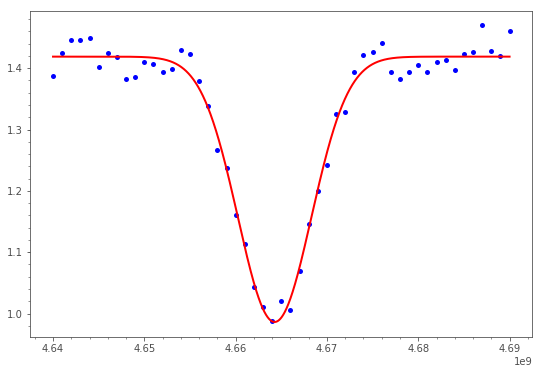

Bias field:  0.06372391648737424 T
FWHM:  9.460040321969545 MHz
Contrast:  30.480942278057242 %


In [8]:
#Analyse bias field
#Gathering data from dictonary
directory = 'G:\\Data\\Qudi_Data\\2024\\06\\20240627\\PODMR\\'
podrm_path = directory + '20240627-1716-23_A-P08-05_NbSe2_S4_rot_2K_70mT_Bnv_OOC_ODMR_data_ch0_range0'+'.dat'
data_raw = np.loadtxt(podrm_path).T
var_list,data = (data_raw[0],data_raw[1])

gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

mode = 'gaussian_dip'
gslac = False
left = False

fwhm_bias = 0
contrast_bias = 0

#Determine fit

if mode == 'double':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N15':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N14':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N14)
    lm,_ = fitlogic.make_lorentziandouble_model()

elif mode == 'gaussian_dip':
    fit = afm_scanner_logic._fitlogic.make_gaussian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_gaussian_dip)
    lm,_ = fitlogic.make_gaussian_model()
    fwhm_bias = fit.params['fwhm'].value*1e-6 #FWHM in MHz
    contrast_bias = fit.params['contrast'].value*-1
    
else:    
    fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
    lm,_ = fitlogic.make_lorentzian_model()

# print(fit.fit_report())
bias_res_freq = fit.params['center'].value

if gslac == True and left == True:
    b_field_bias = np.sqrt(abs(bias_res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field_bias = np.sqrt(abs(bias_res_freq - zero_field)**2 - e_field**2) / gyro_nv

#Plot Data an
plt.plot(var_list,data,'bo')

x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
plt.plot(x, lm.eval(fit.params, x=x),'r-')

plt.show()

print('Bias field: ',b_field_bias,'T')
print("FWHM: ",fwhm_bias,'MHz')
print("Contrast: ",contrast_bias,'%')

data_array['params']['Bias field (T)'] = b_field_bias

In [9]:
res_freq = data_array['res_freq']['data']

gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

gslac = False
left = False

if gslac == True and left == True:
    b_field = np.sqrt(abs(res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field = np.sqrt(abs(res_freq - zero_field)**2 - e_field**2) / gyro_nv
    
stray_field = b_field-b_field_bias

scan_array_x = data_array['res_freq']['coord0_arr']
scan_array_y = data_array['res_freq']['coord1_arr']
scan_start_x = scan_array_x[0]
scan_stop_x = scan_array_x[-1]
scan_start_y = scan_array_y[0]
scan_stop_y = scan_array_y[-1]

# data_array.update({'b_field': {'data': b_field}})
# data_array['b_field']['coord0_arr'] = scan_array_x
# data_array['b_field']['coord1_arr'] = scan_array_y
# data_array['b_field']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
# data_array['b_field']['xy_units'] = 'm'
# data_array['b_field']['si_units'] = 'T'
# data_array['b_field']['nice_name'] = 'Sensed Field: B_NV'

data_array.update({'stray_field': {'data': stray_field}})
data_array['stray_field']['coord0_arr'] = scan_array_x
data_array['stray_field']['coord1_arr'] = scan_array_y
data_array['stray_field']['params'] = {'coord0_start': scan_start_x,'coord0_stop': scan_stop_x,'coord1_start': scan_start_y,'coord1_stop': scan_stop_y}
data_array['stray_field']['xy_units'] = 'm'
data_array['stray_field']['si_units'] = 'T'
data_array['stray_field']['nice_name'] = 'Stray Field: B_NV - B_bias'

with open(filepath+'_jupyter_corrected.pickle', 'wb') as f:
    pickle.dump(data_array, f)
    
save_obj_to_gwyddion(dataobj=data_array,filename=filepath+'_jupyter_corrected.gwy')

######  Run tracking mode

In [47]:
#Tracking test
change_freq = True
res_freq = target_freq_0

for i in range(tracking_repetitions):
    res_freq = run_tracking(res_freq, pi_pulse, power_0, delta_freq, max_sweeps_tracking, slope, upload = False if i>0 else True, change_freq = change_freq)
    print(res_freq)
    change_freq = True

4666934077.049656
4663921157.363665
4660763770.722315
